In [1]:
import pandas as pd
import os

import numpy as np

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pickle

with open('sbert_topic.pickle', 'rb') as file:
    save_dict = pickle.load(file)


ecb_with_topics = pd.DataFrame(
{"date": save_dict["date"],
    "dist": save_dict["dist"],
})
ecb_with_topics.head()


ecb_with_sentiment = pd.read_csv('./ecb_with_sentiment_bert.csv')
ecb_with_sentiment.head()

ecb_with_sentiment=ecb_with_sentiment.drop(columns=["contents"])
# ecb_with_sentiment = ecb_with_sentiment.loc[ecb_with_sentiment.subtitle.str.contains("\sMember\s"),:]

In [3]:
combined = pd.concat([ecb_with_sentiment, ecb_with_topics], axis=1, join='inner')

In [4]:
combined.head()

,Unnamed: 0,date,speakers,title,subtitle,mean,std,pos_mean,pos_std,neu_mean,neu_std,neg_mean,neg_std,pos_np,neu_np,neg_np,date,dist
0,0,2021-05-27,Isabel Schnabel,Societal responsibility and central bank indep...,"Keynote speech by Isabel Schnabel, Member of t...",-0.029951,0.400268,0.163618,0.234120,0.642814,0.305841,0.193568,0.268448,[0.10956815 0.35029936 0.20687319 0.01825724 0...,[0.87274659 0.59361166 0.7798577 0.93721557 0...,[0.01768526 0.05608896 0.01326916 0.04452714 0...,2021-05-27,"[[0.21629815, 0.024413059, 0.052392557, 0.0730..."
1,1,2021-05-27,Luis de Guindos,Climate change and financial integration,"Keynote speech by Luis de Guindos, Vice-Presid...",0.061016,0.530413,0.256416,0.326693,0.548183,0.369853,0.195400,0.319901,[0.09710149 0.02649051 0.04752919 0.82506913 0...,[0.88666415 0.15776695 0.26347992 0.16767293 0...,[0.01623432 0.81574255 0.68899089 0.00725802 0...,2021-05-27,"[[0.018513896, 0.013093044, 0.008514501, 0.029..."
2,3,2021-05-19,Fabio Panetta,At the edge of tomorrow: preparing the future ...,"Introductory remarks by Fabio Panetta, Member ...",0.269950,0.425732,0.347740,0.300367,0.574470,0.314054,0.077790,0.222976,[0.20408778 0.20069633 0.8980974 0.28038397 0...,[0.78265643 0.788921 0.09119311 0.71117795 0...,[0.01325578 0.01038271 0.01070952 0.00843802 0...,2021-05-19,"[[0.16781583, 0.012153944, 0.17001057, 0.01567..."
3,4,2021-05-06,Christine Lagarde,Towards a green capital markets union for Europe,"Speech by Christine Lagarde, President of the ...",0.323093,0.428089,0.397903,0.310706,0.527286,0.306852,0.074811,0.205355,[0.4326309 0.0224579 0.0526524 0.08850522 0...,[0.55388117 0.28344294 0.91742045 0.89186609 0...,[0.01348789 0.69409919 0.02992714 0.01962868 0...,2021-05-06,"[[0.0105395485, 0.011020768, 0.014013605, 0.01..."
4,6,2021-04-29,Frank Elderson,All the way to zero: guiding banks towards a c...,"Keynote speech by Frank Elderson, Vice-Chair o...",0.209064,0.397128,0.291181,0.291513,0.626703,0.303493,0.082117,0.199824,[0.5190323 0.66055119 0.5339638 0.76919842 0...,[0.46750572 0.33069667 0.44952407 0.22248527 0...,[0.01346206 0.00875203 0.01651208 0.0083163 0...,2021-04-29,"[[0.2879435, 0.002589192, 0.0058928146, 0.0012..."


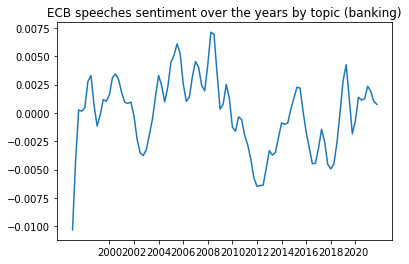

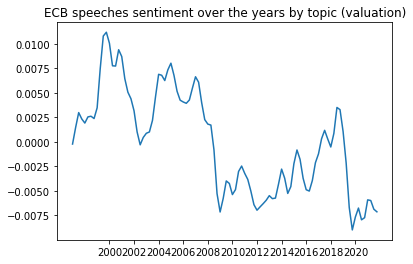

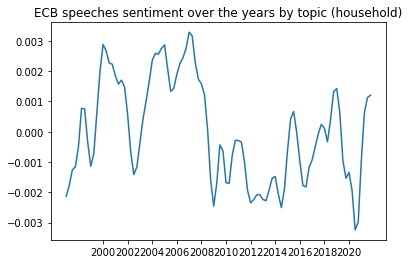

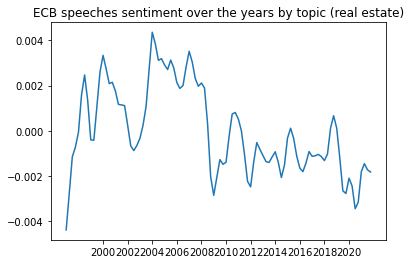

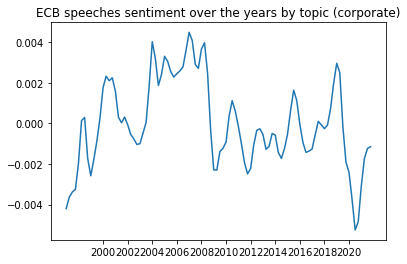

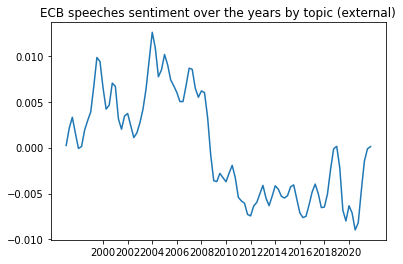

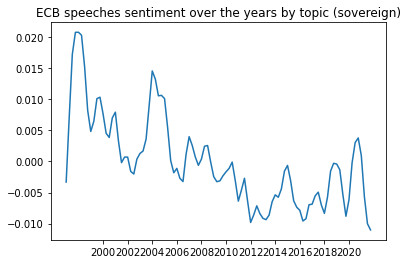

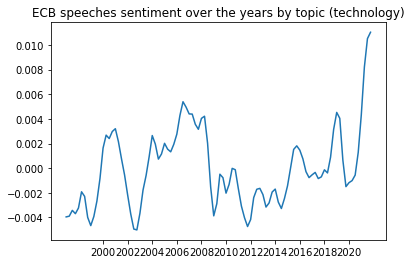

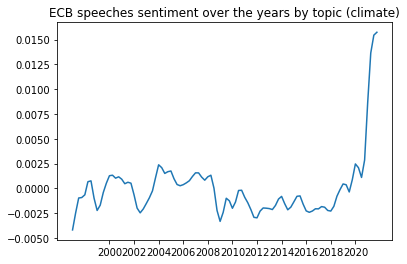

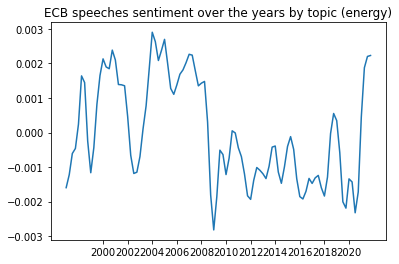

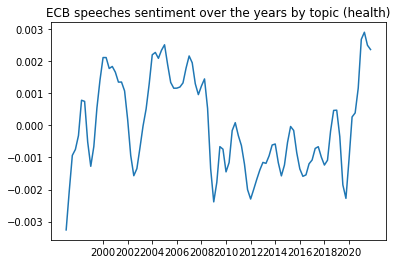

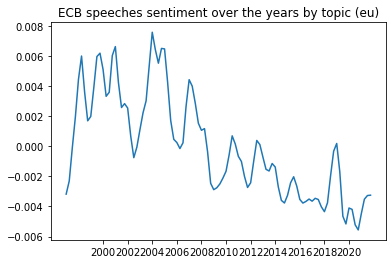

In [5]:

from scipy.ndimage.filters import gaussian_filter1d
# threshold_neutral = 0.6

#0.5 0.5 (no shift mean)
#0.6 0.6 (no shift mean)
threshold_significance = 0
threshold_mean_significance = 0
threshold_significance_fss = 0

# for threshold_neutral in np.linspace(0.9,1,1):

def combine_dist(dist):
    # dist = np.apply_along_axis(renorm, 1, dist)
    return dist.mean(axis=0)    

def remove_neutral(pos, neu, neg, dist):
    pos = np.fromstring(pos[1:-1],sep=' ')
    neu = np.fromstring(neu[1:-1],sep=' ')
    neg = np.fromstring(neg[1:-1],sep=' ')
    combined = np.array([pos,neu,neg]).T #(num_of_sent,3)

    # filtered = combined[neu<threshold_neutral]
    res = dist.T* (combined.T[0]-combined.T[2])
    # res = res[np.abs(res)>threshold_significance]
    return combine_dist(res.T)

def fss(pos, neg):
    pos = np.fromstring(pos[1:-1],sep=' ')
    neg = np.fromstring(neg[1:-1],sep=' ')
    combined = pos - neg
    filtered = combined[np.abs(combined)<threshold_significance_fss]
    filtered = (np.heaviside(filtered, 0) -0.5) *2
    if len(filtered) == 0:
        return 0
    else:
        return filtered.mean()

combined['filtered'] = combined.apply(lambda row: remove_neutral(row['pos_np'],row['neu_np'],row['neg_np'],row['dist']),axis=1)

# ecb_with_sentiment['filtered_mean'] = ecb_with_sentiment.apply(lambda row: row['filtered'].mean(),axis=1)

# ecb_with_sentiment['filtered_std'] = ecb_with_sentiment.apply(lambda row: row['filtered'].std(),axis=1)

# ecb_with_sentiment['fss'] = ecb_with_sentiment.apply(lambda row: fss(row['pos_np'], row['neg_np']),axis=1)


# old = len(ecb_with_sentiment)
# ecb_with_sentiment_new = ecb_with_sentiment[np.abs(ecb_with_sentiment.filtered_mean) > threshold_mean_significance]
# new = len(ecb_with_sentiment_new)
# print(old-new)

# for each time interval (quarterly)
#    check speech overal sentiment
#    plot graph

# quarters = ["({0})".format(i) for i in range(1,13)]
quarters = ["(1|2|3)","(4|5|6)", "(7|8|9)","(10|11|12)"]
# quarters = ["(1|2|3|4|5|6|7|8|9|10|11|12)"]
# quarters = ["(1|2|3|4|5|6)","(7|8|9|10|11|12)"]

col = ["year","banking","valuation","household","real estate","corporate","external","sovereign","technology", "climate", "energy", "health", "eu"] # "fss_mean", "fss_std", "pos_mean", "pos_std", "neg_mean","neg_std"])
 # "fss_mean", "fss_std", "pos_mean", "pos_std", "neg_mean","neg_std"])

quarterly_data = pd.DataFrame(columns = col) 


for year in range(1997,2022):
    for index, quarter in enumerate(quarters):
        data = combined.loc[ecb_with_topics['date'].str.contains(str(year) + '-0?' + quarter + '-'), :]
        # assume sample mean (neglect difference in datapoints)

        topics =data['filtered'].mean()
        if type(topics) != float:
            temp_data = pd.DataFrame([[year , topics[0],topics[1],topics[2],topics[3],topics[4],topics[5],topics[6],topics[7],topics[8],topics[9],topics[10],topics[11]]],columns = col)

    
        quarterly_data = quarterly_data.append(temp_data, ignore_index = True)

quarterly_data.to_csv('./ecb_sentiment_quarterly_bert.csv')


labels = ["banking","valuation","household","real estate","corporate","external","sovereign","technology", "climate", "energy", "health", "eu"]


year = [[ year + index/4 for index in range (0, 4) ]for year in range(1997,2022)]
year = [item for sublist in year for item in sublist]

for label in labels:
    mean = quarterly_data[label].to_numpy()

    mean = gaussian_filter1d(mean, sigma=1)

    shift = np.nan_to_num(mean).mean()

    mean = mean - shift

    # std = quarterly_data['std'].to_numpy()

    # std = gaussian_filter1d(std, sigma=0.3) 
    # fss_mean = quarterly_data['fss_mean'].to_numpy()
    # fss_std = quarterly_data['fss_std'].to_numpy()
    # pos_mean = quarterly_data['pos_mean'].to_numpy()
    # pos_std = quarterly_data['pos_std'].to_numpy()
    # neg_mean = quarterly_data['neg_mean'].to_numpy()
    # neg_std = quarterly_data['neg_std'].to_numpy()

    fig = plt.figure()


    # import scipy.signal as signal

    # sos = signal.butter(536, 35, 'lp', fs=1000, output='sos')
    # filtered = signal.sosfiltfilt(sos, mean)

    x = year
    y = mean * 1
    # yerr = std

    # plt.errorbar(x, y, yerr = yerr)
    plt.plot(x,y)

    # plt.fill_between(x, y-yerr, y+yerr,
    #     alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')

    plt.xticks(np.arange(1997, 2021, 2))
    plt.xlim(2000,2021)
    plt.title(f'ECB speeches sentiment over the years by topic ({label})')

    plt.show()
